# Travail pratique 2
*INF600F - Traitement d'images (H2022, UQÀM)*

## Identification

- Nom : Jacob-Simard
- Prénom : Raphaël
- Code permanent : JACR26038907
- Cours : INF600f - H2022
- Équipe : 9

In [1]:
# Importation des modules pertinents ici. 
# Assurez-vous d'inclure toute autre fonction que vous
# jugez nécessaires ici

import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter, convolve, correlate
from skimage.transform import rescale


# importation d'images

EX1_PAD = np.mean(imageio.imread("image_00.jpg"), axis=2)
EX2_FREQ = imageio.imread("tp2_ex2.tif")
EX3_FILTRE = imageio.imread("tp2_ex3.tif")

# Exercice 1 : Filtrage spatial (9 pts)

In [2]:
def _creer_both(f: np.ndarray, r: int, c: int, padType: str) -> np.ndarray:
    
    f_p = np.zeros((f.shape[0] + r*2, f.shape[1] + c*2))
    f_p[r:-r, c:-c] = f

    if padType != "zeros":
        f_p[:r, c:-c] = f[-r:,:] # cote haut
        f_p[-r : , c:-c] =  f[:r, :] # cote bas
        f_p[r:-r, :c] = f[:, -c:] # cote gauche
        f_p[r:-r, -c:] = f[:, :c] # cote droit
        f_p[:r, :c] = f[-r:, -c:] # coin haut-gauche
        f_p[:r, -c:] = f[-r:, :c] # coin haut-droit
        f_p[-r:, :c] = f[:r, -c:] # coin bas-gauche
        f_p[-r:, -c:] = f[:r, :c] # coin bas-droit
    return f_p

In [3]:
def _creer_post(f: np.ndarray, r: int, c: int, padType: str) -> np.ndarray:
    f_p = np.zeros((f.shape[0] + r, f.shape[1] + c)) 
    f_p[:-r, :-c] = f
    if padType != "zeros":
        f_p[-r : , :-c] =  f[:r, :] # cote bas
        f_p[:-r, -c:] = f[:, :c] # cote droit
        f_p[-r:, -c:] = f[:r, :c] # coin bas-droit

        
    return f_p

In [4]:
def imgPad(f, r, c, padType='zeros', loc='both'):
    """Ajoute un padding à une image
    
    Parameters
    ----------
    f : ndarray
        Image à modifier
    r : int
        Taille du padding pour les lignes
    c : int
        Taille du padding pour les colonnes
    padType : str
        Type de padding. Valeurs possibles : 'zeros', 'replicate'
    loc : str
        Position du padding. Valeurs possibles : 'both' ou 'post'
    Returns
    -------
    f_p : ndarray
        Image avec un padding ajouté
    """
    if padType not in ["zeros", "replicate"] :
        raise ValueError(f"Erreur dans le paramètre 'padType' = {padType}. Valeurs valides : 'zeros' | 'replicate'.")
    if loc not in ["post", "both"] :
        raise ValueError(f"Erreur dans le paramètre 'loc' = {loc}. Valeurs valides : 'both' | 'post'.")
    f_copy = f.copy()
    return _creer_both(f_copy, r, c, padType) if loc == "both" else _creer_post(f_copy,r,c, padType)

    

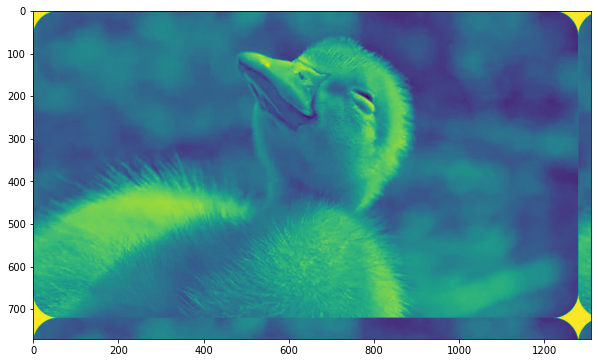

In [5]:
padded = imgPad(EX1_PAD, 50, 30,loc="post", padType="replicate")


plt.figure(figsize=(10,10))
plt.subplot(111)
plt.imshow(padded)
plt.show()

In [6]:
def twodConv(f, w, normalize=True):
    """ Effectue une convolution 2D de l'image f avec le noyau w

    Parameters
    ----------
    f : ndarray
        Image convoluer
    w : ndarray
        Noyau/filtre pour la convolution
    normalize : bool
        Si True, les intensités de l'image f doivent être normalisées entre 0 et 1
    Returns
    -------
    f_p : ndarray
        Image convoluée
    Notes
    -----
    * La fonction imgPad créée dans la partie précédente doit être utilisée.
    """
    f_p = imgPad(f, w.shape[0], w.shape[1], loc="both", padType="replicate")

    #plt.imshow(f_p)

    if normalize :
        f_p = (f_p - f_p.min()) / (f_p.max() - f_p.min())

    f_p = convolve(f_p, w)

    f_p = f_p[w.shape[0]: - w.shape[0], w.shape[1]:-w.shape[1]]
    
    
    return f_p

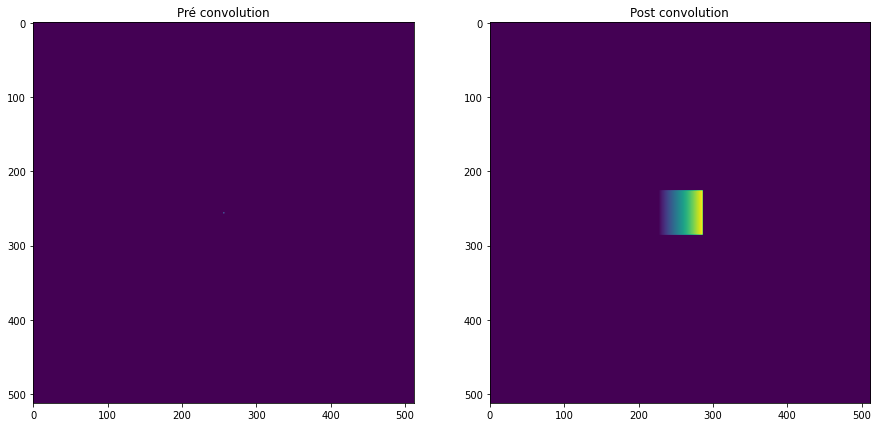

In [7]:


img = np.zeros((512,512))
img[256,256] = 1


_, filtre_g = np.meshgrid(np.linspace(0,1,60), np.linspace(0,1,60), indexing="ij")

img_c = twodConv(img, filtre_g)


plt.figure(figsize=(15,15))
plt.subplot(121)
plt.title("Pré convolution")
plt.imshow(img)
plt.subplot(122)
plt.title("Post convolution")
plt.imshow(img_c)
plt.show()



### Explications pour l'exercice 1

Pour prouver que la fonction twodConv() fonctionne bien, j'ai créé un filtre sur un gradient de 0 à 1 allant de gauche à droite pour bien démontrer le fait que la convolution 'flip' le filtre avant d'être appliquée. Si une corrélation était appliquée, l'image inverse du filtre serait affichée puisque le coin supérieur gauche(par exemple) serait à 1.

Dans l'affichage post-convolution, on voit que l'impulsion originale est transformée pour être la même chose que le filtre. Cela a du sens puisqu'une convolution applique un filtre 'opposé' à chaque pixel d'une image. Bien entendu, du rembourrage est ajouté pour empêcher des erreurs lors de la convolution. Cela ne change rien pour cette image, mais cela pourrait avoir de l'importance pour une autre.



# Exercice 2 : Transformée de Fourier (6 pts)

In [8]:
def display_fft(img_fft):
    """Affichage de l'amplitude et de la phase d'une transformée de Fourier
    
    Parameters
    ----------
    img_fft : ndarray
        Transformée de Fourier d'une image
    """
    img_fft_shift = np.fft.fftshift(img_fft)
    amplitude = np.abs(img_fft_shift)
    phase = np.angle(img_fft_shift)

    freq = np.fft.fftshift(np.fft.fftfreq(1024))
    extent = (freq[0], freq[-1], freq[-1], freq[0])

    # Affichage de l'amplitude et de la phase de la transformée de fourier
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.title("Amplitude")
    plt.imshow(np.log(amplitude +1e-6), extent=extent)
    plt.subplot(122)
    plt.title("Phase")
    plt.imshow(phase, extent=extent)

    plt.show()

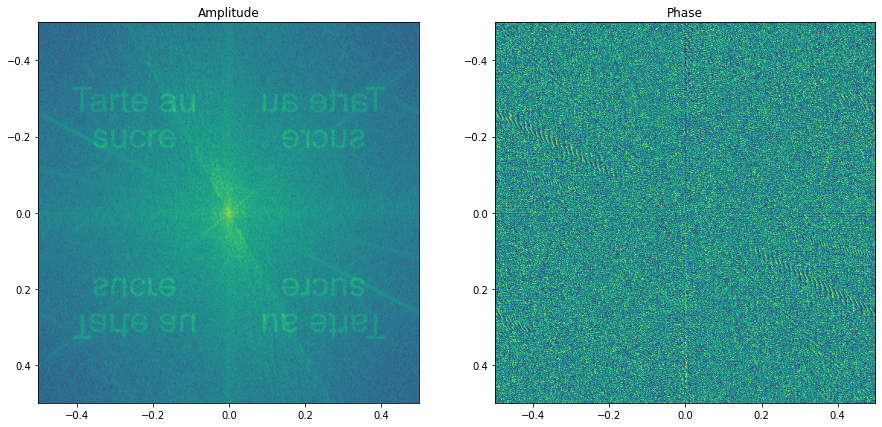

In [9]:
img_fft = np.fft.fft2(EX2_FREQ)
display_fft(img_fft)


### Message secret

'Tarte au sucre' sur les 4 quadrants

### Comment est-il crypté

#### Quelques observations

Le message est plutôt loin du centre, ce qui révèle qu'il est formé de hautes fréquences.

L'image est composée en majorité de basses fréquences, ce qui est normal.

L'image au complet semble avoir des artéfacts ressemblant à des vagues ou du tissage.

#### Méthode utilisée

Je pense que la méthode utilisée consiste à ajouter le secret voulu à l'image en représentation fréquentielle(avec fftshift appliqué) et ensuite de retourner l'image en fft normal avec ifftshift avant de convertir l'image en domaine spacial avec ifft2. Après quelques tests, il est définitivement possible d'insérer des secrets de cette manière bien que je ne connais pas la méthode exacte pour donner le meilleur résultat. Il faut bien entendu mette le message dans quatres quadrants(positif ou négatif). 

Le message est imperceptible dans l'image en représentation spaciale parce qu'il est de faible amplitude par rapport aux basses fréquences et qu'il est lui même composé de hautes fréquences.

# Exercice 3 : Filtrage fréquentiel (10 pts)

In [10]:
def _func_ideal(P, Q, param):
    def H(u, v):
        d = ((u - P/ 2)**2 + (v - Q/2)**2) ** (1/2)
        return 1 if d <= param else 0

    return H

In [11]:
def _func_gaussian(P, Q, param):
    def H(u, v):
        d = ((u - P/ 2)**2 + (v - Q/2)**2) ** (1/2)
        return np.exp((-d**2) / (2*param**2))
    return H

In [12]:
def _func_butterworth(P, Q, param):
    def H(u,v):
        d = ((u - P/ 2)**2 + (v - Q/2)**2) ** (1/2)
        return 1 / (1 + (d / param[0])**(2*param[1]))
    return H

In [13]:
def lpFilterTF(type, P, Q, param):
    """Crée un filtre passe bas fréquentiel
    
    Parameters
    ----------
    type : str
        Type de filtre. Valeurs possibles : 'ideal', 'gaussian', 'butterworth'
    P : int
        Nombre de ligne du filtre
    Q : int
        Nombre de colonne du filtre
    param : float ou list
        Si type='ideal' ou type='gaussian', param=d0
        Si type='butterworth', type=[d0,n]

    Returns
    -------
    H : ndarray
        Filtre fréquentiel passe bas de taille PxQ
    
    """

    if type not in ["ideal", "gaussian", "butterworth"]:
        raise ValueError(f"Valeur de 'type' : {type} invalide. Valeurs valides : 'ideal', 'gaussian', 'butterworth'.")
    if P < 1 or Q < 1:
        raise ValueError(f"Valeur de P ou Q <= 0. Ces valeurs doivent être strictement positives.")
    
    H = None
    
    if type == "ideal" or type == "gaussian":
        if not (isinstance(param, float) or isinstance(param, int)):
            raise TypeError(f"Type de 'param' invalide {type(param)}. <float> attendu pour un filtre gaussian ou ideal.")
        if type == "ideal":
            H = _func_ideal(P, Q, param)
        elif type == "gaussian":
            H = _func_gaussian(P, Q, param)
            
    elif type == "butterworth":
        if not isinstance(param, list):
            raise TypeError(f"Type de 'param' invalide {type(param)}. <list> de taille 1x2 attendu pour un filtre butterworth.")
        H = _func_butterworth(P, Q, param)

    return H

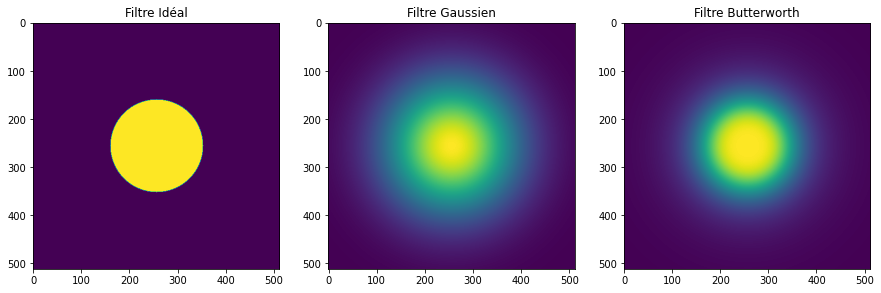

In [14]:
ideale = lpFilterTF("ideal", 512, 512, 96.0)

gaussian = lpFilterTF("gaussian", 512, 512, 96.0)

butter = lpFilterTF("butterworth", 512, 512, [96.0, 2])

filtreI = np.zeros((512,512))
for x in range(filtreI.shape[0]):
    for y in range(filtreI.shape[1]):
        filtreI[x,y] = ideale(x,y)

filtreG = np.zeros((512,512))
for x in range(filtreG.shape[0]):
    for y in range(filtreG.shape[1]):
        filtreG[x,y] = gaussian(x,y)
    
filtreB = np.zeros((512,512))
for x in range(filtreB.shape[0]):
    for y in range(filtreB.shape[1]):
        filtreB[x,y] = butter(x,y)

plt.figure(figsize=(15,15))   
plt.subplot(131) 
plt.title("Filtre Idéal")
plt.imshow(filtreI)
plt.subplot(132) 
plt.title("Filtre Gaussien")
plt.imshow(filtreG)
plt.subplot(133) 
plt.title("Filtre Butterworth")
plt.imshow(filtreB)
plt.show()

In [37]:
c = 256
d = 50
n = 1

ideale = lpFilterTF("ideal", c, c, 60)
gaussian = lpFilterTF("gaussian", c, c, 35)
butter = lpFilterTF("butterworth", c, c, [d,n])


filtreI = np.zeros((c,c))
for x in range(filtreI.shape[0]):
    for y in range(filtreI.shape[1]):
        filtreI[x,y] = ideale(x,y)

filtreG = np.zeros((c,c))
for x in range(filtreG.shape[0]):
    for y in range(filtreG.shape[1]):
        filtreG[x,y] = gaussian(x,y)
    
filtreB = np.zeros((c,c))
for x in range(filtreB.shape[0]):
    for y in range(filtreB.shape[1]):
        filtreB[x,y] = butter(x,y)




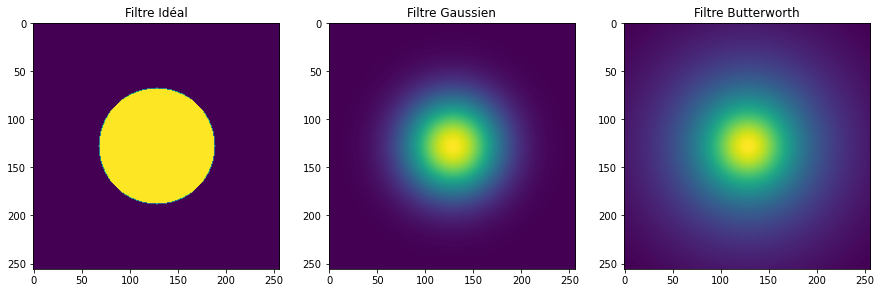

In [38]:
plt.figure(figsize=(15,15))   
plt.subplot(131) 
plt.title("Filtre Idéal")
plt.imshow(filtreI)
plt.subplot(132) 
plt.title("Filtre Gaussien")
plt.imshow(filtreG)
plt.subplot(133) 
plt.title("Filtre Butterworth")
plt.imshow(filtreB)
plt.show()

In [41]:
# Transformée de Fourier des filtres et de l'images
img_pad_ex3 = imgPad(EX3_FILTRE, c, c, loc="post", padType="replicate")
i_size = EX3_FILTRE.shape[0] + c
img_fft = np.fft.fft2(img_pad_ex3)
img_fft_i = np.fft.fft2(1 - img_pad_ex3)
filtreI_fft = np.fft.fft2(filtreI, (i_size, i_size))
filtreG_fft = np.fft.fft2(filtreG, (i_size, i_size))
filtreB_fft = np.fft.fft2(filtreB, (i_size, i_size))


# Application du filtre sur le domaine fréquentiel

filtrerI_fft = img_fft * filtreI_fft
filtrerG_fft = img_fft * filtreG_fft
filtrerB_fft = img_fft_i * filtreB_fft


# Tranformée de Fourier inverse des images

lim = c//2
filtrerI = np.fft.ifft2(filtrerI_fft).real[lim : -lim, lim: -lim]
filtrerG = np.fft.ifft2(filtrerG_fft).real[lim : -lim, lim: -lim]
filtrerB = np.fft.ifft2(filtrerB_fft).real[lim : -lim, lim: -lim]

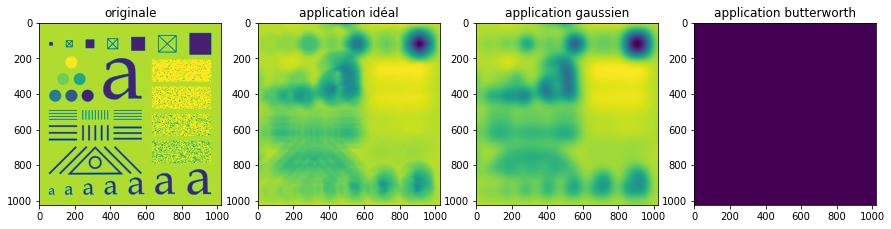

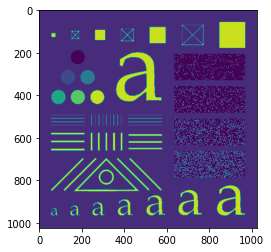

In [47]:


# affichage des images après lissage des différents filtres
filtrerB[filtrerB < 0.4] = 0
plt.figure(figsize=(15,15))
plt.subplot(141)
plt.title("originale")
plt.imshow(EX3_FILTRE)
plt.subplot(142)
plt.title("application idéal")
plt.imshow(filtrerI)
plt.subplot(143)
plt.title("application gaussien")
plt.imshow(filtrerG)
plt.subplot(144)
plt.title("application butterworth")
plt.imshow(filtrerB)
plt.show()


plt.imshow(1-EX3_FILTRE)
plt.show()